# Intro to language model

Part 1 - Intro to language modeling:
- Counting bigrams in 2D torch tensor ("training")
- From counts to probabilities (vectorization)
- Sampling from the model
- Loss function
- Smoothing

Part 2 - Simple MLP for Language Modeling:
- Understanding the model
- Simple training loop

Part 3 - Learning subword tokens

Sources: 
- https://github.com/karpathy/nn-zero-to-hero
- https://github.com/karpathy/makemore

Resources:
- https://huggingface.co/course/chapter1/1

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# download the names.txt file from github
!wget -O names.txt https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-12 19:37:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-05-12 19:37:03 (8.38 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()

In [5]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
len(words)

32033

In [7]:
min(len(w) for w in words)

2

In [8]:
max(len(w) for w in words)

15

Example Bigrams

In [9]:
# Show the bigram examples

## Part 1 - Intro to language modeling

### Counting bigrams in 2D torch tensor ("training")

In [10]:
vocab_dim = 27

In [11]:
# https://pytorch.org/docs/stable/torch.html#creation-ops
# Rows: first character, columns: second character
N = torch.zeros((vocab_dim, vocab_dim), dtype=torch.int32)
# Check the the shape
N

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],


Example Tensor/Indexing/Manipulation

In [12]:
# Create a mapping from character to index and from index to character
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [13]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

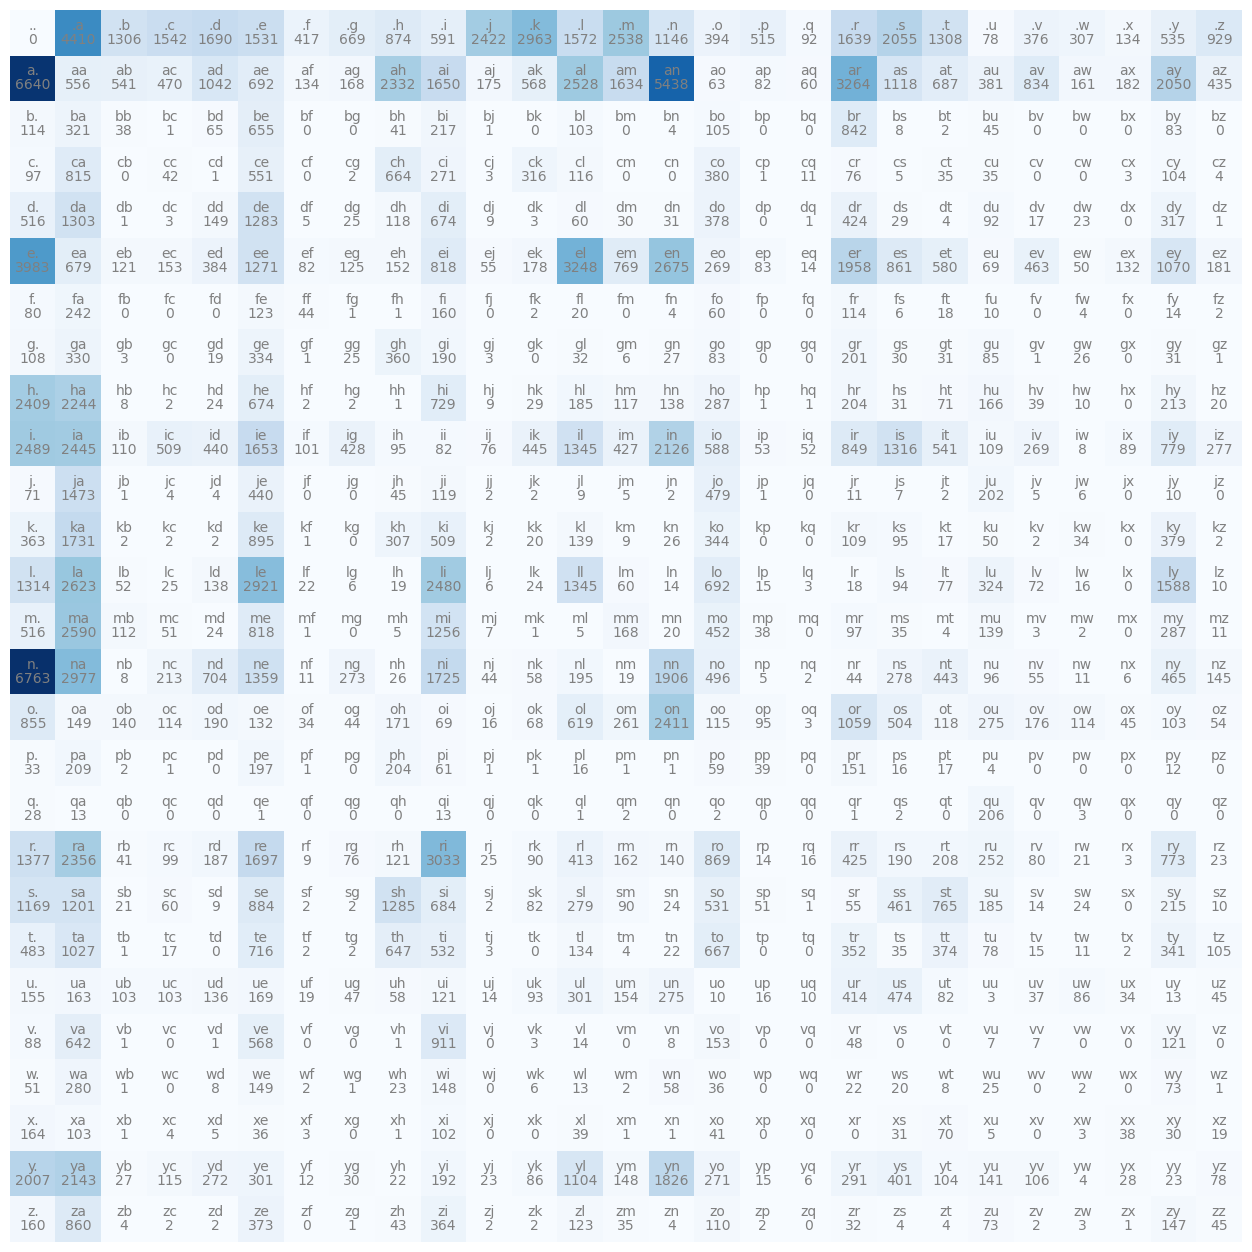

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(vocab_dim):
    for j in range(vocab_dim):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### From counts to probabilities

In [15]:
N[0,:]


tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

Simple normalizing

In [16]:
# Simple normalizing
p = N[-1].float()
# Divides each element of p by the sum of p
p = p / p.sum()
p

tensor([0.0667, 0.3586, 0.0017, 0.0008, 0.0008, 0.1555, 0.0000, 0.0004, 0.0179,
        0.1518, 0.0008, 0.0008, 0.0513, 0.0146, 0.0017, 0.0459, 0.0008, 0.0000,
        0.0133, 0.0017, 0.0017, 0.0304, 0.0008, 0.0013, 0.0004, 0.0613, 0.0188])

Normalizing with broadcasting

In [17]:
# Broadcasting
# https://pytorch.org/docs/stable/notes/broadcasting.html
P = N.float()
# Dim and keep dim
row_sum = P.sum(dim=1, keepdim=True)
print(row_sum.shape)
# Normalize (Copy the column sums across columns)
P /= row_sum

torch.Size([27, 1])


In [18]:
# 27, 27
# 27, 1

In [19]:
P.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [20]:
# Pitfalls of broadcasting
P = N.float()
# dim=1, keep_dim=False
row_sum = P.sum(dim=1)
P /= row_sum
print(row_sum.shape)

torch.Size([27])


In [21]:
P.sum(1)

tensor([7.0225, 4.4142, 0.2009, 0.3717, 0.4146, 2.2968, 0.1063, 0.2065, 0.4567,
        2.3526, 0.2220, 0.3551, 1.0512, 0.4841, 1.3317, 1.1396, 0.1160, 0.0719,
        1.1012, 0.8395, 0.5237, 0.5898, 0.1441, 0.0669, 0.1164, 0.8289, 0.1753])

In [22]:
# 27, 27
#  1  27
# ==> Copys sum across columns over the rows

### Sampling

Starting from the "." token

In [23]:
g = torch.Generator().manual_seed(42)
# What is ix telling us
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
# What is itos[ix]?
# itos[ix]

Generating names

In [24]:
g = torch.Generator().manual_seed(42)

for i in range(1):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out[:-1]))

ye


In [25]:
#Compare against the uniform model

### Loss function
https://en.wikipedia.org/wiki/Maximum_likelihood_estimation

In [26]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling) ==> Slide 9, Lecture 2
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [27]:
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["wilhelm"]: # "wilhelmq"
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559994.)
nll=tensor(559994.)
2.4545421600341797


### Additive Smoothing
https://en.wikipedia.org/wiki/Additive_smoothing

In [28]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

## Part 2 - Simple MLP for Language Modeling
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

### Understanding the model

In [29]:
# Build the training data

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [30]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [31]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


### Why do we split into train, dev and test ###
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [32]:
# Embedding Matrix
C = torch.randn((27, 2)).to(device)

In [33]:
# Dummy training examples
X.shape

torch.Size([32, 3])

In [34]:
X[0]
# print("".join([itos[x.item()] for x in X[0]]))

tensor([0, 0, 0], device='cuda:0')

In [35]:
# one = F.one_hot(X[0], num_classes=27).float()
# one @ C
# h = (one @ C).mean(0)

In [36]:
# Indexing
C[X[0]]
# C[[0,0,0]]
# C[[0,0,0]].shape

tensor([[-0.8742, -0.0459],
        [-0.8742, -0.0459],
        [-0.8742, -0.0459]], device='cuda:0')

In [37]:
# Index our training examples from our embedding matrix
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [38]:
# Reshaping tensors
# emb[0].view(1,6)
# emb[0].view(-1,6)

In [39]:
# First linear layer | What is the dimension?
W1 = torch.randn((6, 100)).to(device)
b1 = torch.randn(100).to(device)

In [40]:
# Dense intermediate representation of our input
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [41]:
h

tensor([[ 0.8471, -0.2392, -0.7762,  ..., -0.1326,  0.5389, -0.9898],
        [ 0.5157, -0.9634, -0.4555,  ...,  0.5184,  0.7751, -0.9969],
        [ 0.9619, -0.9539, -0.7822,  ...,  0.3866,  0.8709,  0.7874],
        ...,
        [ 0.4542,  0.8870,  0.2749,  ..., -0.8321, -0.3367, -0.3073],
        [ 0.4440, -0.9593, -0.9545,  ...,  0.3764, -0.9038, -0.2136],
        [ 0.7465, -0.7388, -0.8022,  ...,  0.9964, -0.7801, -0.1768]],
       device='cuda:0')

In [42]:
h.shape

torch.Size([32, 100])

In [43]:
# Up-projection | What is the dimension?
W2 = torch.randn((100, 27)).to(device)
b2 = torch.randn(27).to(device)

In [44]:
logits = h @ W2 + b2

In [45]:
logits.shape

torch.Size([32, 27])

In [46]:
counts = logits.exp()

In [47]:
prob = counts / counts.sum(1, keepdims=True)

In [48]:
prob.shape

torch.Size([32, 27])

In [49]:
F.softmax(logits, dim=1).allclose(prob)

True

In [50]:
Y[:5]

tensor([ 5, 13, 13,  1,  0], device='cuda:0')

In [51]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [52]:
loss = -prob[torch.arange(32), Y].log().mean()
loss.item()

16.9759521484375

In [53]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       device='cuda:0')

In [54]:
F.cross_entropy(logits, Y).allclose(loss)

True

### Simple training loop

In [55]:
#---putting it together---
vocab_size = len(itos)
emb_dim = 2
block_size = 3
h_dim = 100
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, emb_dim), generator=g).to(device)
W1 = torch.randn((emb_dim * block_size, h_dim), generator=g).to(device)
b1 = torch.randn(h_dim, generator=g).to(device)
W2 = torch.randn((h_dim, vocab_size), generator=g).to(device)
b2 = torch.randn(vocab_size , generator=g).to(device)
parameters = [C, W1, b1, W2, b2]

In [56]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [57]:
for p in parameters:
    print(p.requires_grad)

False
False
False
False
False


In [58]:
for p in parameters:
  p.requires_grad = True

In [59]:
lr=0.1
max_steps = 100000
losses = []
batch_size = 32

for i in range(max_steps):
    # Batching
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,)).to(device) # What do we get here?
    
    # Forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, emb_dim) => (32, 3, 2)
    h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Reset gradients
    for p in parameters:
        p.grad = None
        
    # Backward pass
    loss.backward()
    
    # Stochastic gradient descent
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())

      0/ 100000: 20.3165
  10000/ 100000: 2.6623
  20000/ 100000: 2.2452
  30000/ 100000: 2.4177
  40000/ 100000: 2.2528
  50000/ 100000: 2.6959
  60000/ 100000: 2.5409
  70000/ 100000: 2.4801
  80000/ 100000: 2.2779
  90000/ 100000: 2.1554


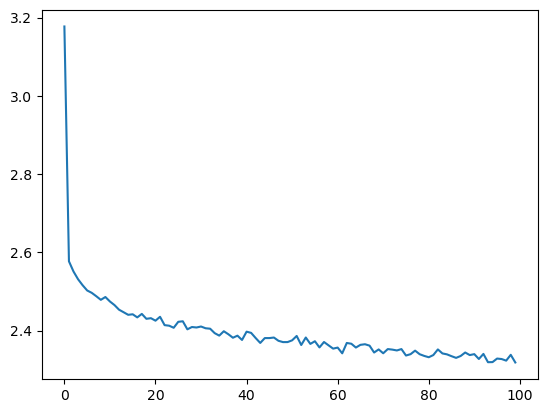

In [60]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [61]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.3599820137023926
val 2.364985704421997


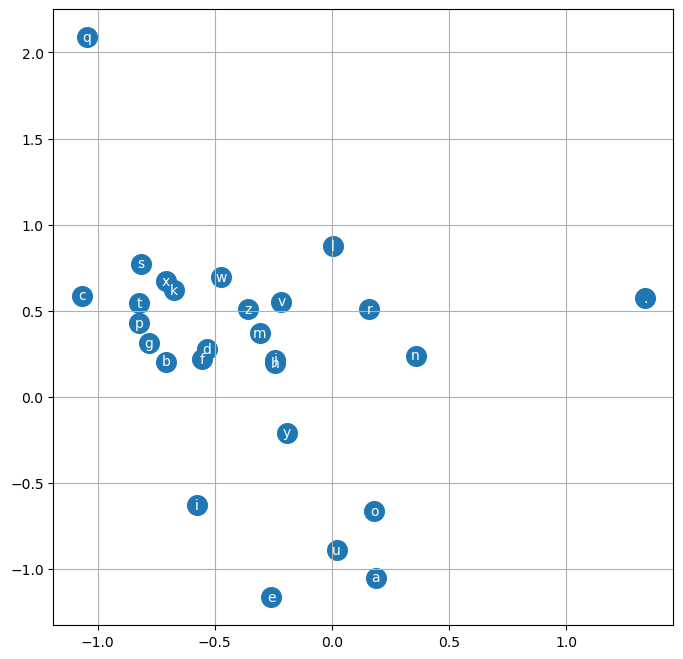

In [62]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].cpu().data, C[:,1].cpu().data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [63]:
# sample from the model
g = torch.Generator(device=device).manual_seed(42)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context]).to(device)] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1]))

kritarikahiranie
dadar
evlie
airishaishaizelliva
basin
avargemin
wiigono
ony
ausin
mari
izamiolyiastona
kahlean
kahasidot
dozariohalli
edi
jadilonathan
aaterrie
arayahneyke
tahariza
rionag


How to get to CBOW
- One hot indexing
- Averaging of embeddings
- Simple up-projection

## Part 3: Learning subword tokens (WordPiece)
https://arxiv.org/pdf/1609.08144.pdf

In [64]:
# 1. Example single word "word"
corpus = "word"
vocab = ['w', '##o', '##r', '##d']
split_corpus = [('w', '##o', '##r', '##d', 1)]

In [65]:
# f(t1,t2)/(f(t1)*f(t2))
# Intuition: Dampen the effect of generally frequent tokens

In [66]:
# 2. Example 
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u"]
split_corpus = ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##g" "##s", 5)
# First merge ==> ##g,##s ==> ##gs
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs"]
split_corpus = ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##gs", 5)
# Second merge ==> h, ##u
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu"]
split_corpus = ("hu" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)
# Third merge ==> hu, ##g
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu", "hug"]
split_corpus = ("hug", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)
# Continue until desired vocab size is reached

In [67]:
# Tokenization of token "hugs"
# 1. Find longest subword starting from the beginning in the vocabulary ==> "hug"
# 2. Split the token:
split = ["hug", "##s"]
# 1. Find longest subword starting from the beginning in the vocabulary ==> "##s"
tokenization = ["hug", "##s"]

In [68]:
# Tokenization of the token "mug"
# 1. Find longest subword starting from the beginning in the vocabulary ==> "[UNK]" ("m" is not in the vocabulary)
tokenization = ["[UNK]"]

In [69]:
# Tokenization of the word "bum"
# 1. Find longest subword starting from the beginning in the vocabulary ==> "b"
# 2. Split the token:
split = ["b", "##um"]
# 1. Find longest subword starting from the beginning in the vocabulary ==> "##u"
# 2. Split the token:
split = ["b", "##u", '##m']
# 1. Find longest subword starting from the beginning in the vocabulary ==> "[UNK]"
tokenization = ["[UNK]"]

In [70]:
# Apply text preprocessing (normalization, pre-tokenization) if working text 

# Getting the word frequencies
word_freqs = defaultdict(int)
for word in words:
    word_freqs[word] += 1

print(list(word_freqs.items()))
# word_freqs

[('yuheng', 1), ('diondre', 1), ('xavien', 1), ('jori', 2), ('juanluis', 1), ('erandi', 1), ('phia', 1), ('samatha', 1), ('phoenix', 2), ('emmelynn', 1), ('hollan', 1), ('hollis', 2), ('callalily', 1), ('adelayde', 1), ('josephyne', 1), ('weldon', 1), ('kayle', 1), ('ragnar', 1), ('colbie', 2), ('taveon', 1), ('aki', 2), ('peyten', 1), ('kevari', 1), ('joella', 1), ('mecca', 2), ('egan', 1), ('justyce', 2), ('taliyah', 1), ('hayley', 1), ('alleah', 1), ('kymberlynn', 1), ('parrish', 2), ('houstyn', 1), ('jamaya', 1), ('ahmod', 1), ('nivin', 1), ('milli', 1), ('cristiana', 1), ('jaimee', 1), ('mitchell', 2), ('nairah', 1), ('lorena', 1), ('gentrie', 1), ('torrion', 1), ('savian', 1), ('benjamine', 1), ('airess', 1), ('knute', 1), ('sultana', 1), ('danai', 1), ('azzan', 1), ('issabelle', 1), ('abrahim', 1), ('aislyn', 1), ('aerys', 2), ('malaiya', 1), ('kieon', 1), ('ayansh', 1), ('berklee', 2), ('emmakate', 1), ('avaneesh', 1), ('amenadiel', 1), ('renardo', 1), ('brekken', 1), ('kamry',

In [71]:
# Getting the alphabet (pre-vocab)
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
print(alphabet)
        

['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [72]:
# In case of pretrained language models more special tokens are used ("[UNK]", "[CLS]", ...)
vocab = ["."] + alphabet.copy()
print(vocab)

['.', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [73]:
# Create our splitted corpus: {"emma": [e, ##m, ##m, ##a]}
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}
print(list(splits.items())[:5])

[('yuheng', ['y', '##u', '##h', '##e', '##n', '##g']), ('diondre', ['d', '##i', '##o', '##n', '##d', '##r', '##e']), ('xavien', ['x', '##a', '##v', '##i', '##e', '##n']), ('jori', ['j', '##o', '##r', '##i']), ('juanluis', ['j', '##u', '##a', '##n', '##l', '##u', '##i', '##s'])]


In [74]:
# "Training" aka learn the merges
# Compute the score for each pair that can be constructed from splits
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items(): 
        split = splits[word] 
        if len(split) == 1:
            # Word is a single token
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            # Construct pairs from left to right
            pair = (split[i], split[i + 1])
            # Update the frequency of the current "letter"/subword
            letter_freqs[split[i]] += freq
            # Update the frequency of the pair
            pair_freqs[pair] += freq
        # Update the frequency of the last "letter"/subword
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [75]:
# Let´s look at the first scores
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('y', '##u'): 5.258346861347788e-05
('##u', '##h'): 2.814127736363198e-06
('##h', '##e'): 4.106151828818785e-06
('##e', '##n'): 8.056479724665693e-06
('##n', '##g'): 1.2399544029901778e-05
('d', '##i'): 4.495796430337634e-06


In [76]:
# Get the best pair
max(pair_scores.items(), key=lambda kv: kv[1])

(('q', '##u'), 0.0002915617755401004)

In [77]:
# Append to vocab
vocab.append("qu")

In [78]:
# Apply the update vocabulary to splits
def merge_pair(a, b, splits):
    for word in word_freqs: # yuheng
        split = splits[word] # ['y', '##u', '##h', '##e', '##n', '##g']
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [79]:
splits = merge_pair("q", "##u", splits)
splits["quinn"]

['qu', '##i', '##n', '##n']

In [80]:
# Let´s build our vocabulary
vocab_size = 200
while len(vocab) < vocab_size:
    # Compute pair scores
    scores = compute_pair_scores(splits)
    # Get best pair
    best_pair, max_score = max(scores.items(), key=lambda kv: kv[1])
    # Update splits / corpus (merge)
    splits = merge_pair(*best_pair, splits)
    # Add new token to vocab
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [81]:
print(vocab)

['.', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu', 'qw', '##qu', '##ff', '##pp', '##xx', '##ck', 'iz', 'izz', 'iq', '##uq', 'ruq', 'luq', 'luqm', '##ouq', '##rouq', '##ruq', 'gw', 'xz', 'yu', 'yux', 'yuxu', 'yuv', 'yuxi', 'yuj', 'yuji', 'uz', 'uzz', 'uzzi', 'qwy', 'qwyn', 'qwynn', '##cqu', 'qwe', 'qwes', 'qwest', '##uw', '##luw', 'oluw', '##juw', 'ruw', 'juw', '##suw', '##oluw', '##juwo', 'toluw', 'ow', '##foluw', '##nfoluw', '##infoluw', '##yinfoluw', '##iyinfoluw', 'fiyinfoluw', '##juwon', '##xxw', '##esuw', '##desuw', 'adesuw', '##xxwe', '##xxwel', '##xxwell', '##ph', 'up', 'upt', 'upto', 'upton', 'yuk', '##cque', '##cqul', '##cquez', '##cquli', '##cqulin', '##cquel', '##cques', '##cquely', '##cquelyn', '##cquline'

In [82]:
# Encode a word, search for the longest substring
def encode_word(word): # emma
    tokens = []
    while len(word) > 0:
        i = len(word) # i = 4
        while i > 0 and word[:i] not in vocab:
            i -= 1
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [83]:
print(encode_word("emma"))
print(encode_word("quinn"))

['emm', '##a']
['qu', '##i', '##n', '##n']


### Coding Exercises:
- "Train" a subword level bigram or a character level trigram model
- "Train" a character level bigram model on tiny shakespeare
- Train a character level bigram model with stochastic gradient descent (no counting, but learn the probabilities via gradient descent and backprop)
- Train a simple MLP on tiny shakespeare
- Add the residual connection to the simple MLP

### 

### Pen & Paper Exercises:

- Build the subword vocabulary with a vocabulary size of 10 for the following sentence: "hug pup hug pup pun hugs hug pup un" using WordPiece. Don´t add the "." token to your alphabet.
    - Solution: ['##g', '##n', '##p', '##s', '##u', 'h', 'p', 'u', 'un', '##gs']
- Tokenize the word "hug" with your learned vocabulary using WordPiece.
    - Solution: ['h', '##u', '##g']
- Compute the character-level bigram probabilities for the following corpus using additive smoothing (+ 1): ["baba", "abba", "abba", "abab", "bbba"]. Build all possible bigrams: ["..", ".a", ".b", "a.", "b.", "aa", "ab", "ba", "bb"].
    - Solution:
        - ..: 0.125
        - .a: 0.500
        - .b: 0.3750
        - a.: 0.4167
        - b.: 0.1429
        - aa: 0.0833
        - ab: 0.5000
        - ba: 0.5000
        - bb: 0.3571
- Compute the unnormalized negative log-likelihood of the word "bab" in your character-level bigram model:
    - Solution: 4.3130
- Compute the logits for a CBOW model
    - Sentence: "Frodo and Sam fight the orks"
    - Vocab: ["Frodo", "Sam", "fight", "the", "orks"]
    - Compute the logits for a CBOW model for the word "fight" being the center word with a window size of 2 given the matrics W1 and W2 (below)
    - Solution: [ 0.6394, -0.7976, -0.1091,  1.5486, -0.9377]
- What are the differences between BPE and WordPiece and SentencePiece?

In [ ]:
W1 = 
[[ 0.4128, -0.2592, -0.5713, -0.9116],
 [-0.6286,  0.1850,  0.8611,  0.3844],
 [ 2.0777,  0.2960, -0.7118,  1.0722],
 [-1.0484,  0.9931,  0.2309,  2.5170],
 [ 1.8805,  1.0564,  1.7468,  0.2562]]

In [ ]:
W2 =
[[-0.9120, -0.7972, -0.1510, -0.0237, -0.1716],
 [-0.0279, -0.2131, -1.2196, -0.1247,  0.0168],
 [ 0.9730, -1.0510, -0.6692,  1.5317, -1.4178],
 [ 0.4312,  0.0468,  1.5954,  1.3278, -0.2063]]